# ANALYSE PREDICTIVE

In [1]:
## Importation des données

#utilisation de la librairie Pandas
#spécialisée - entres autres - dans la manipulation des données

# Pandas : Python Data Analysis Library. Très
# pratique pour la manipulation des données, avec
# un type data.frame inspiré de R

import pandas
#header = 0, la première ligne (n°0) correspond aux noms de variables
pima = pandas.read_table("pima.txt",sep="\t",header=0)

#dimensions
# 768 lignes (obs.) et 9 colonnes (variables)
print("Dimensions: ")
print(pima.shape)

#liste des colonnes
print("\nColonnes:")
print(pima.columns)

#liste des colonnes et leurs types
print("\nTypes")
print(pima.dtypes)

Dimensions: 
(768, 9)

Colonnes:
Index(['pregnant', 'diastolic', 'triceps', 'bodymass', 'pedigree', 'age',
       'plasma', 'serum', 'diabete'],
      dtype='object')

Types
pregnant       int64
diastolic      int64
triceps        int64
bodymass     float64
pedigree     float64
age            int64
plasma         int64
serum          int64
diabete       object
dtype: object


In [2]:
## Subdivision en échantillons d’apprentissage et de test

#transformation en matrice numpy - seul reconnu par scikit-learn
data = pima.values

#X matrice des var. explicatives
X = data[:,0:8]

#y vecteur de la var. à prédire
y = data[:,8]

#utilisation du module model_selection de scikit-learn (sklearn)
from sklearn import model_selection

#subdivision des données – éch.test = 300 ; éch.app = 768 – éch.test = 468
X_app,X_test,y_app,y_test = model_selection.train_test_split(X,y,test_size = 300,random_state=0)
print(X_app.shape,X_test.shape,y_app.shape,y_test.shape)

(468, 8) (300, 8) (468,) (300,)


In [3]:
## Construction du modèle sur l’échantillon d’apprentissage

#à partir du module linear_model du package sklearn
#importer la classe LogisticRegression
from sklearn.linear_model import LogisticRegression

#création d'une instance de la classe
lr = LogisticRegression(solver='liblinear')

#exécution de l'instance sur les données d'apprentissage
#c.à-d. construction du modèle prédictif
modele = lr.fit(X_app,y_app)

#les sorties sont très pauvres à la différence des logiciels de stat
#les coefficients…
print(modele.coef_,modele.intercept_)

[[ 8.75153769e-02 -1.59511103e-02  1.70428483e-03  5.18609374e-02
   5.34696503e-01  1.24335202e-02  2.40115458e-02 -2.91586161e-04]] [-5.13527961]


In [4]:
## Prédiction et évaluation sur l’échantillon test

#prediction sur l'échantillon test
y_pred = modele.predict(X_test)

#importation de metrics - utilisé pour les mesures de performances
from sklearn import metrics

#matrice de confusion
#confrontation entre Y obs. sur l’éch. test et la prédiction
cm = metrics.confusion_matrix(y_test,y_pred)
print(cm)

#taux de succès
acc = metrics.accuracy_score(y_test,y_pred)
print("\nTaux de succès:")
print(acc)

#taux d'erreur
err = 1.0 - acc
print("\nTaux d'erreur:")
print(err)

#sensibilité (ou rappel)
se = metrics.recall_score(y_test,y_pred,pos_label='positive')
print("\nSensibilité:")
print(se)

[[184  17]
 [ 45  54]]

Taux de succès:
0.7933333333333333

Taux d'erreur:
0.20666666666666667

Sensibilité:
0.5454545454545454


In [5]:
## Construction de sa propre mesure de performance (ex. Spécificité)

#écrire sa propre func. d'éval - ex. specificité
def specificity(y,y_hat):
    
    #matrice de confusion – un objet numpy.ndarray
    mc = metrics.confusion_matrix(y,y_hat)

    #’’negative’’ est sur l'indice 0 dans la matrice
    import numpy
    res = mc[0,0]/numpy.sum(mc[0,:])
    return res

#la rendre utilisable - transformation en objet scorer
specificite = metrics.make_scorer(specificity,greater_is_better=True)

#utilisation de l’objet scorer
#remarque : modele est le modèle élaboré sur l’éch. d’apprentissage
sp = specificite(modele,X_test,y_test)
print(sp) # 0.915 = 184 / (184 + 17)


0.9154228855721394


# VALIDATION CROISÉE

Problème : lorsque l’on traite un petit fichier (en nombre d’obs.), le schéma apprentissage – test est pénalisant <br/>
apprentissage : on réduit l’information disponible pour créer le modèle ; <br/>
test : un faible effectif produit des estimationsdes performances très instables). <br/>

Solution : <br/>
(1) construire le modèle sur la totalité des données, <br/>
(2) évaluer les performances à l’aide des techniques de ré-échantillonnage (ex. validation croisée)


In [6]:
#importer la classe LogisticRegression
from sklearn.linear_model import LogisticRegression

#création d'une instance de la classe
lr = LogisticRegression(solver='liblinear')

#exécution de l'instance sur la totalité des données (X,y)
modele_all = lr.fit(X,y)

#affichage
print(modele_all.coef_,modele_all.intercept_)

#utilisation du module model_selection
from sklearn import model_selection

#évaluation en validation croisée : 10 cross-validation
succes = model_selection.cross_val_score(lr,X,y,cv=10,scoring='accuracy')

#détail des itérations
print(succes)

#moyenne des taux de succès = estimation du taux de succès en CV
print(succes.mean())

[[ 1.17087631e-01 -1.68947770e-02  7.46053001e-04  5.97221654e-02
   6.81392866e-01  7.21999666e-03  2.83788475e-02 -6.42978367e-04]] [-5.88988049]
[0.74025974 0.75324675 0.79220779 0.72727273 0.74025974 0.74025974
 0.81818182 0.79220779 0.73684211 0.82894737]
0.7669685577580314


# SCORING

Ex. de ciblage : faire la promotion d’un produit auprès d’un ensemble de clients <br/>
Objectif : contacter le moins de personnes possible, obtenir le max. d’achats <br/>
Démarche : attribuer un score aux individus, les trier de manière décroissante (score élevé = forte appétence au produit), estimer à l’aide de la courbe de gain le nombre d’achats en fonction d’une taille de cible choisie. <br/>
Remarque : L’idée peut être transposée à d’autres domaines (ex. dépistage de maladie)

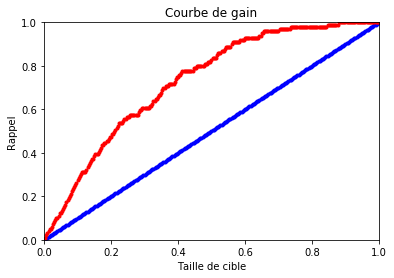

In [9]:
## Construction de la courbe de gain

#classe Régression Logistique
from sklearn.linear_model import LogisticRegression

#création d'une instance de la classe
lr = LogisticRegression(solver='liblinear')

#modélisation sur les données d'apprentissage
modele = lr.fit(X_app,y_app)

#calcul des probas d'affectation sur ech. test
probas = lr.predict_proba(X_test)

#score de 'presence'
score = probas[:,1]

#transf. en 0/1 de Y_test
pos = pandas.get_dummies(y_test).values

#on ne récupère que la 2è colonne (indice 1)
pos = pos[:,1]

#nombre total de positif
import numpy
npos = numpy.sum(pos)

#index pour tri selon le score croissant
index = numpy.argsort(score)

#inverser pour score décroissant – on s’intéresse à forte proba. en priorité
index = index[::-1]

#tri des individus (des valeurs 0/1)
sort_pos = pos[index]

#somme cumulée
cpos = numpy.cumsum(sort_pos)

#rappel
rappel = cpos/npos

#nb. obs ech.test
n = y_test.shape[0]

#taille de cible – séquence de valeurs de 1 à 300 avec un pas de 1
taille = numpy.arange(start=1,stop=301,step=1)

#passer en proportion
taille = taille / n

#graphique avec matplotlib
import matplotlib.pyplot as plt

#titre et en-têtes
plt.title('Courbe de gain')
plt.xlabel('Taille de cible')
plt.ylabel('Rappel')

#limites en abscisse et ordonnée
plt.xlim(0,1)
plt.ylim(0,1)

#astuce pour tracer la diagonale
plt.scatter(taille,taille,marker='.',color='blue')

#insertion du couple (taille, rappel)
plt.scatter(taille,rappel,marker='.',color='red')

#affichage
plt.show()


# GRID SEARCH

Problème : De nombreux algorithmes demachine learning reposent sur des paramètres qui ne sont pas toujours évidents à déterminer pour obtenir les meilleurs performances sur un jeu de données à traiter. Ex. SVM.

In [12]:
## Dépendances des algorithmes d’apprentissage aux paramètres

#svm
from sklearn import svm

#par défaut un noyau RBF et C = 1.0
mvs = svm.SVC(gamma='auto')

#modélisation
modele2 = mvs.fit(X_app,y_app)

#prédiction ech. test
y_pred2 = modele2.predict(X_test)

#matrice de confusion
print(metrics.confusion_matrix(y_test,y_pred2))

#succès en test
print('\nSuccès:')
print(metrics.accuracy_score(y_test,y_pred2))

#C’est la méthode (SVM) qui est inapte ou c’est le paramétrage qui est inadapté ?

[[201   0]
 [ 99   0]]

Succès:
0.67


In [14]:
## Détermination des meilleurs valeurs des paramètres

# Stratégie : Grille de recherche. On indique les paramètres à faire varier, scikit-learn les croise et mesure
# les performances en validation croisée.

#import de la classe
from sklearn import model_selection

#combinaisons de paramètres à évaluer
parametres = [{'C':[0.1,1,10],'kernel':['rbf','linear']}]

#évaluation en validation croisée de 3 x 2 = 6 configurations
#accuracy sera le critère à utiliser pour sélectionner la meilleure config
#mvs est l’instance de la classe svm.SVC (cf. page précédente)
grid = model_selection.GridSearchCV(estimator=mvs,param_grid=parametres,scoring='accuracy')

#lancer la recherche – attention, gourmand en calculs
grille = grid.fit(X_app,y_app)

#résultat pour chaque combinaison
print(pandas.DataFrame.from_dict(grille.cv_results_).loc[:,["params","mean_test_score"]])

#meilleur paramétrage
print("\nMeileur paramétrage:")
print(grille.best_params_)

#meilleur performance – estimée en interne par validation croisée
print("\nMeileure performance:")
print(grille.best_score_)

#prédiction avec le modèle « optimal » c.-à-d. {‘C’ : 10, ‘kernel’ : ‘linear’}
y_pred3 = grille.predict(X_test)

#taux de succès en test
print("\nSuccès:")
print(metrics.accuracy_score(y_test,y_pred3))

D:\Software\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


                           params  mean_test_score
0     {'C': 0.1, 'kernel': 'rbf'}         0.638889
1  {'C': 0.1, 'kernel': 'linear'}         0.752137
2       {'C': 1, 'kernel': 'rbf'}         0.638889
3    {'C': 1, 'kernel': 'linear'}         0.747863
4      {'C': 10, 'kernel': 'rbf'}         0.638889
5   {'C': 10, 'kernel': 'linear'}         0.756410

Meileur paramétrage:
{'C': 10, 'kernel': 'linear'}

Meileure performance:
0.7564102564102564
\Succès:
0.7833333333333333


# SELECTION DE VARIABLES

Objectif : la sélection de variables - la recherche de modèles parcimonieux - présente plusieurs avantages : interprétation, déploiement (moins de var. à renseigner), performances en généralisation (ou du moins maintien des performances). <br/>
Méthode : Nous implémentons la méthode RFE de scikit-learn : elle élimine au fur et à mesure les coefficients les plus faibles en valeur absolue (étrange : les variables ne sont pas toujours à la même échelle ??? une standardisation des variables paraît nécessaire), et s’arrête quand on arrive à la moitié ou à un nombre spécifié de variables.

In [19]:
## Sélection de variables

#importer la classe LogisticRegression
from sklearn.linear_model import LogisticRegression

#création d'une instance de la classe
lr = LogisticRegression(solver='liblinear')

#algorithme de sélection de var.
from sklearn.feature_selection import RFE
selecteur = RFE(estimator=lr)

#lancer la recherche
sol = selecteur.fit(X_app,y_app)

#nombre de var. sélectionnées
print("\nNb de valeurs:")
print(sol.n_features_)

#liste des variables sélectionnées
# Variables sélectionnées : pregnant, bodymass, pedigree, plasma.

print("\nVariables:")
print(sol.support_)

#ordre de suppression
print("\nOrdre de suppression:")
print(sol.ranking_) 

# Serum a été retirée en premier, puis triceps, puis âge, puis diastolic. Les variables restantes sont indexées 1.

#réduction de la base d'app. aux var. sélectionnées
#en utilisant le filtre booléen sol.support_
X_new_app = X_app[:,sol.support_]

#construction du modèle sur les explicatives sélectionnées
modele_sel = lr.fit(X_new_app,y_app)

#réduction de la base test aux mêmes variables
X_new_test = X_test[:,sol.support_]

#prédiction du modèle réduit sur l’éch. test
y_pred_sel = modele_sel.predict(X_new_test)

#évaluation
print("\nSuccès après réévaluation:")
print(metrics.accuracy_score(y_test,y_pred_sel))

#Aussi bien (presque, 0.793) que le modèle initial, mais avec moitié moins de variables.


Nb de valeurs:
4

Variables:
[ True False False  True  True False  True False]

Ordre de suppression:
[1 2 4 1 1 3 1 5]

Succès après réévaluation:
0.7866666666666666
